In [1]:
import pandas as pd
from pandas import DataFrame
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from mpl_toolkits.mplot3d import axes3d
from keras import backend as K
import gc
#from color_tools import *
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
import pandas as pd
from pandas import DataFrame
import matplotlib as mat
import tempfile
import shutil
import warnings
import PIL
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.metrics import pairwise_distances_argmin
import cv2
import sys


2024-02-27 10:34:15.646658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 10:34:16.270191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-27 10:34:16.270236: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-02-27 10:34:16.270242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [37]:
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

def create_shifted_frames_2(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, data.shape[1]-1, :, :]
    return x, y

def agroup_window(data, window):
    new_data = [data[i:window+i] for i in range(len(data)-window+1)]
    return np.array(new_data)

def to_monochromatic(img_data, min_val= 10, max_val= 255):
    x_mono = []
    for i in img_data:
        (thresh, monoImg) = cv2.threshold(i, min_val, max_val, cv2.THRESH_BINARY)
        x_mono.append(monoImg)
    x_mono = np.array(x_mono)
    return x_mono

def add_last(data, new_vals):
    print(data.shape)
    x_test_new = data[:,1:]
    print(x_test_new.shape)
    print(new_vals.shape)
    l = []
    for i in range(len(x_test_new)):
        l.append(np.append(x_test_new[i], new_vals[i]))
    x_test_new = np.array(l).reshape(data.shape[:])
    print("CX", x_test_new.shape)
    return x_test_new

def limit_memory():
    """ Release unused memory resources. Force garbage collection """
    K.clear_session()
    gc.collect()

#Toma todos los colores existentes en la imagen
def get_colors(image):
  aux = []
  band = True
  for i in image:
    for j in i:
      for k in aux:
        if j.tolist() == k:
          band = False
          break
      if band:
        aux.append(j.tolist())
      band = True
  return np.array(aux)

#Obtiene los n colores principales mediante kmeans
def principal_colors(img, n_colors):
  photo = img
  photo = photo/255
  w,h,d = tuple(photo.shape)
  #assert d == 3
  photo = photo.reshape(w*h, d)
  photo_sample = shuffle(photo, random_state=0)[:1000]
  kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(photo_sample)
  labels = kmeans.predict(photo)
  return labels, kmeans

#Recrea una imagen comprimida por la función de kmaens por un codebook
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

#Función para transformar y obtener los colores principales de una imagen
def n_colors_img(img, n_colors):
  labels, model = principal_colors(img, n_colors)
  w,h,d = tuple(img.shape)
  print(labels)
  res = recreate_image(model.cluster_centers_, labels, w, h)
  res = np.round(res*255).astype(np.uint8)
  return res

#Función para dada una paleta solo tomar los colores de esa paleta en la imagen
def quantizetopalette(silf, palette, dither=False, mode="P"):
  """Convert an RGB or L mode image to use a given P image's palette."""
  silf.load()
  palette.load()
  im = silf.im.convert(mode, 0, palette.im)
  # the 0 above means turn OFF dithering making solid colors
  return silf._new(im)

#Realiza las operaciones necesarias para obtener una imagen RGB por una paleta de colores
def rgb_quantized(img, palette):
  rows, cols = len(img), len(img[0])
  total_vals = 1
  for i in palette.shape:
    total_vals *= i
  palettedata = palette.reshape(total_vals).tolist()
  palImage = Image.new('P', (rows, cols))
  palImage.putpalette(palettedata*32)
  oldImage = Image.fromarray(img).convert("RGB")
  newImage = quantizetopalette(oldImage,palImage)
  res_image = np.asarray(newImage.convert("RGB"))
  return res_image

def balance_img_categories(img, palette, balancer):
  #palette = np.sort(palette)
  rows = len(img)
  cols = len(img[0])
  for i in range(rows):
    for j in range(cols):
      pos = np.where(palette == img[i,j])[0][0]
      img[i,j] = balancer[pos]
  return img

def balance_img_categories_vectorized(img, palette, balancer):
    # Crear un array vacío del mismo tamaño que img para almacenar los resultados
    balanced_img = np.empty_like(img)
    
    # Iterar sobre cada valor único en la paleta
    for value in np.unique(img):
        # Encontrar la posición de este valor en la paleta
        pos = np.where(palette == value)[0][0]
        # Usar np.where para asignar el valor correspondiente de balancer a todas las posiciones donde el valor actual ocurre en img
        balanced_img = np.where(img == value, balancer[pos], balanced_img)
    
    return balanced_img



window = 21
channels = 1
rows = 122
cols = 360
categorical = False
categories = [0, 35, 70, 119, 177, 220, 255] #[0,51,102,153,204,255]
horizon = 4


In [50]:
x = np.load("/media/mccdual2080/Almacenamiengto/ManuelProjects/ImageForecasting/Models/Data_full_select_color.npy")
print("dtypes", x.dtype)
print("shape", x.shape)

dtypes float32
shape (1183, 122, 360, 3)


In [51]:
x = np.load("/media/mccdual2080/Almacenamiengto/ManuelProjects/ImageForecasting/Models/Data_full_select_color.npy") * 255
x = x.astype(np.uint8)
#Obtención de la paleta de colores, se toma una imagen muestra
aux = x[1168]


In [53]:
res = n_colors_img(aux, 6)
print(res.shape)
print("min", np.min(res))
print("max", np.max(res))

[1 1 1 ... 1 1 1]
(122, 360, 3)
min 0
max 254


/home/mccdual2080/anaconda3/envs/cropImage/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [55]:

colors = get_colors(res)
print(len(colors))
print(colors.shape)


6
(6, 3)


In [40]:

#Se utiliza una función de cuantificación en las imágenes para que
# todas las imágenes manejen una paleta de colores.
aux_data = np.array([rgb_quantized(i, colors) for i in x])
print(aux_data.shape)


(1183, 122, 360, 3)


In [41]:

#Se comprueban los colores obtenidos
c1 = get_colors(aux_data[0])
c2 = get_colors(aux_data[1167])
print(c1)
print(c2)


[[  0   0   0]
 [254 253   2]
 [253 165   2]
 [116  12   0]
 [254 209 116]]
[[  0   0   0]
 [254 253   2]
 [254 209 116]
 [253 165   2]
 [229   5   0]
 [116  12   0]]


In [42]:

#Se transforma el dataset de colores a escala de grieses, cv2 para mejor calidad.
x_greys = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in aux_data])
#np.save('Models/Data_full_select_greys.npy', x_greys)


In [43]:

colors_greys = get_colors(x_greys[1168])
cg1 = get_colors(x_greys[0])
cg2 = get_colors(x_greys[1167])
print(cg1)
print(cg2)


[  0 178 126  20 186]
[  0 178 186 126  29  20]


In [44]:

a1 = x_greys[0]
a2 = x_greys[1167]
x_greys = np.array([balance_img_categories_vectorized(img, colors_greys, categories) for img in x_greys])
ig1 = x_greys[0]
ig2 = x_greys[1167]
print(get_colors(ig1))
print(get_colors(ig2))


[  0  35  70 220 119]
[  0  35 119  70 177 220]


In [45]:

x = x_greys.astype('float32') / 255

In [47]:
print(x.shape)
print("get_colors", get_colors(x[0]))
print("get_colors", get_colors(x[1167]))


(1183, 122, 360)
get_colors [0.         0.13725491 0.27450982 0.86274511 0.46666667]
get_colors [0.         0.13725491 0.46666667 0.27450982 0.69411767 0.86274511]


Displaying frames for example 394


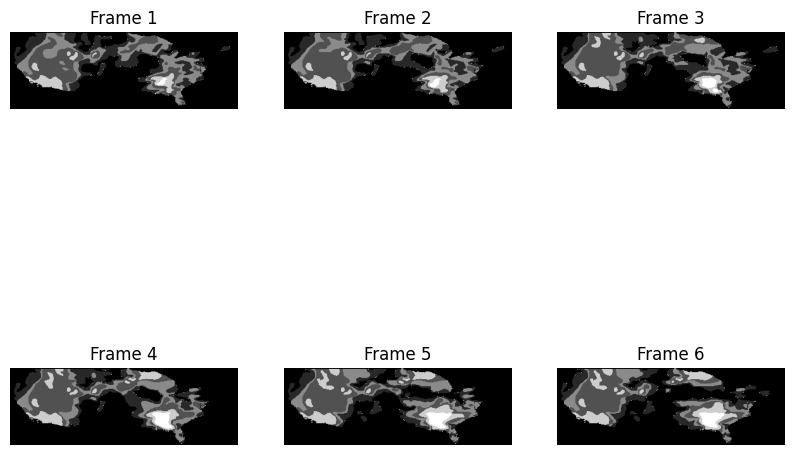

In [49]:

#Mostrar imágenes
fig, axes = plt.subplots(2, 3, figsize= (10,8))

data_choise = np.random.choice(range(len(x)), size= 10)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(x[data_choise+idx]), cmap='gray')
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

print("Displaying frames for example {}".format(data_choise))
plt.show()


In [ ]:

x_2 = agroup_window(x, window)
print(x_2.shape)
x_train = x_2[:int(len(x_2)*.7)]
x_test = x_2[int(len(x_2)*.7):]
x_validation = x_train[int(len(x_train)*.8):]
x_train = x_train[:int(len(x_train)*.8)]

#x_trian = x_train.astype('float32') / 255
#x_validation = x_validation.astype('float32') / 255
#x_test = x_test.astype('float32') / 255
x_train = x_train.reshape(len(x_train), window, rows, cols, channels)
x_validation = x_validation.reshape(len(x_validation), window, rows, cols, channels)
x_test = x_test.reshape(len(x_test), window, rows, cols, channels)

print("Forma de datos de entrenamiento: {}".format(x_train.shape))
print("Forma de datos de validación: {}".format(x_validation.shape))
print("Forma de datos de pruebas: {}".format(x_test.shape))

x_train, y_train = create_shifted_frames_2(x_train)
x_validation, y_validation = create_shifted_frames_2(x_validation)
x_test, y_test = create_shifted_frames_2(x_test)

print("Training dataset shapes: {}, {}".format(x_train.shape, y_train.shape))
print("Validation dataset shapes: {}, {}".format(x_validation.shape, y_validation.shape))
print("Test dataset shapes: {}, {}".format(x_test.shape, y_test.shape))

np.save("DroughtDatasetMask/Resultados/Resultado2x2Categorico/x_test_convlstm_greys_forecast.npy", x_test)
np.save("DroughtDatasetMask/Resultados/Resultado2x2Categorico/y_test_convlstm_greys_forecast.npy", y_test)

#Mostrar imágenes
#fig, axes = plt.subplots(2, 3, figsize= (10,8))

#data_choise = np.random.choice(range(len(x_2)), size= 1)[0]
#for idx, ax in enumerate(axes.flat):
#    ax.imshow(np.squeeze(x_2[data_choise][idx]), cmap='gray')
#    ax.set_title(f"Frame {idx + 1}")
#    ax.axis("off")

#print("Displaying frames for example {}".format(data_choise))
#plt.show()

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    #Construction of Convolutional LSTM network
    inp = keras.layers.Input(shape=(None, *x_train.shape[2:]))

    #It will be constructed a 3 ConvLSTM2D layers with batch normalization,
    #Followed by a Conv3D layer for the spatiotemporal outputs.

    m = keras.layers.ConvLSTM2D(16, (5,5), padding= "same", return_sequences= True, activation= "relu")(inp)
    m = keras.layers.BatchNormalization()(m)
    m = keras.layers.ConvLSTM2D(16, (5,5), padding= "same", return_sequences= True, activation= "relu")(m)
    m = keras.layers.BatchNormalization()(m)
    m = keras.layers.ConvLSTM2D(16, (3,3), padding= "same", activation= "relu")(m)
    m = keras.layers.Conv2D(channels, (3,3), activation= "sigmoid", padding= "same")(m)

    model = keras.models.Model(inp, m)
    model.compile(loss= "binary_crossentropy", optimizer= "Adam")

    print(model.summary())

    #Callbacks
    early_stopping = keras.callbacks.EarlyStopping(monitor= "val_loss", patience= 6, restore_best_weights= True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor= "val_loss", patience= 4)

    #Define moifiable training hyperparameters
    epochs = 20
    batch_size = 2

    #Model training
    model.fit(
        x_train, y_train,
        batch_size= batch_size,
        epochs= epochs,
        validation_data= (x_validation, y_validation),
        callbacks= [early_stopping, reduce_lr]
    )

    example = x_test[np.random.choice(range(len(x_test)), size= 1)[0]]

    #frames = example[:4, ...]
    #original_frames = example[4:, ...]
    print(example.shape)
    #print(frames.shape)
    #print(original_frames.shape)

    for _ in range(horizon):
        print(example.shape)
        new_prediction = model.predict(example.reshape(1,*example.shape[0:]))
        example = np.concatenate((example[1:], new_prediction), axis=0)
        print(example.shape)

    predictions = example[:-4]
    print(predictions.shape)
    #fig, axes = plt.subplots(2,4, figsize= (20,4))
    #for idx, ax in enumerate(axes[0]):
    #    ax.imshow((predictions[idx]), cmap='gray')
    #    ax.set_title("Frame {}".format(idx+3))
    #    ax.axis("off")
    #plt.show()
    err = model.evaluate(x_test, y_test, batch_size= 2)
    print("El error del modelo es: {}".format(err))
    preds = model.predict(x_test, batch_size= 2)
    print(preds.shape)
    x_test_new = add_last(x_test, preds[:])
    preds2 = model.predict(x_test_new, batch_size= 2)
    #print(preds2.shape)
    x_test_new = add_last(x_test_new, preds2[:])
    preds3 = model.predict(x_test_new, batch_size= 2)
    x_test_new = add_last(x_test_new, preds3[:])
    preds4 = model.predict(x_test_new, batch_size= 2)
    res_forecast = add_last(x_test_new, preds4[:])
    print("PREDSS",res_forecast.shape)
    if categorical:
        np.save("DroughtDatasetMask/Resultados/Resultado2x2Categorico/PredictionsConvolutionLSTM_greys_forecast_1.npy", res_forecast)
    else:
        np.save("DroughtDatasetMask/Resultados/Resultado2x2Categorico/PredictionsConvolutionLSTM_forecast_8_w20.npy", res_forecast)
    raise
    try:
        for _ in range(horizon):
            new_prediction = model.predict(example)
            example = np.concatenate((example[0:], new_prediction), axis=0)
            print(example.shape)

            #new_prediction = model.predict(np.expand_dims(frames, axis= 0),batch_size= 2)
            #new_prediction = np.squeeze(new_prediction, axis= 0)
            #predicted_frame = np.expand_dims(new_prediction[-1, ...], axis= 0)

            #frames = np.concatenate((frames, predicted_frame), axis= 0)
        raise
        fig, axes = plt.subplots(2,4, figsize= (20,4))
        for idx, ax in enumerate(axes[0]):
            ax.imshow(np.squeeze(original_frames[idx]), cmap='gray')
            ax.set_title("Frame {}".format(idx+3))
            ax.axis("off")

        new_frames = frames[4:, ...]
        for idx, ax in enumerate(axes[1]):
            ax.imshow(np.squeeze(new_frames[idx]), cmap='gray')
            ax.set_title("F Frame {}".format(idx+3))
            ax.axis("off")

        plt.show()
    except:
        print("Cannot display forecast, continuing for evaluation")

    err = model.evaluate(x_test, y_test)
    print("El error del modelo es: {}".format(err))

    preds = model.predict(x_test)
    print(preds.shape)

    #aux = preds[:,-1]
    #aux = aux.reshape(aux.shape[0], 1, aux.shape[1], aux.shape[2], aux.shape[3])
    #print(aux.shape)
    #x_test_new = x_test[:,1:]
    #print(x_test_new.shape)
    #l = []
    #for i in range(len(x_test_new)):
    #    l.append(np.append(x_test_new[i], aux[i]))
    #x_test_new = np.concatenate((x_test_new, aux), axis=1)
    #x_test_new = np.array(l).reshape(x_test.shape[:])
    #print(x_test_new.shape)
    x_test_new = add_last(x_test, preds[:,-1])
    preds2 = model.predict(x_test_new)
    #print(preds2.shape)
    x_test_new = add_last(x_test_new, preds2[:,-1])
    preds3 = model.predict(x_test_new)
    x_test_new = add_last(x_test_new, preds3[:,-1])
    preds4 = model.predict(x_test_new)
    print(preds4.shape)
    
    try:
        pos = 100
        fig, axes = plt.subplots(5, window-1, figsize= (20,30))
        for idx, ax in enumerate(axes[0]):
            if idx == window-1:
                break
            ax.imshow(np.squeeze(x_test_new[pos][idx]), cmap= 'gray')
            ax.set_title(f"Original t_{pos+idx}")
            #ax.set_title(f"Original")
            ax.axis("off")

        for idx, ax in enumerate(axes[1]):
            if idx == window-1:
                break
            ax.imshow(np.squeeze(preds[pos][idx]), cmap= 'gray')
            ax.set_title(f"preds t_{pos+idx}")
            #ax.set_title(f"Original")
            ax.axis("off")
        
        for idx, ax in enumerate(axes[2]):
            if idx == window-1:
                break
            ax.imshow(np.squeeze(preds2[pos][idx]), cmap= 'gray')
            ax.set_title(f"Preds2 t_{pos+idx}")
            #ax.set_title(f"Original")
            ax.axis("off")
        
        for idx, ax in enumerate(axes[3]):
            if idx == window-1:
                break
            ax.imshow(np.squeeze(preds3[pos][idx]), cmap= 'gray')
            ax.set_title(f"preds3 t_{pos+idx}")
            #ax.set_title(f"Original")
            ax.axis("off")
        
        for idx, ax in enumerate(axes[4]):
            if idx == window-1:
                break
            ax.imshow(np.squeeze(preds4[pos][idx]), cmap= 'gray')
            ax.set_title(f"Preds4 t_{pos+idx}")
            #ax.set_title(f"Original")
            ax.axis("off")
    except:
        print("Cannot display")

    plt.show()

    print(preds4.shape)

    np.save("Models/PredictionsConvolutionLSTM_greys_forecast.npy", preds4)